# Machine Learning Approach: Conditional Random Fields (CRF)

In [ ]:
# Reference
# https://www.kaggle.com/code/bavalpreet26/ner-using-crf
# https://www.kaggle.com/code/marusagar/identifying-entities-in-healthcare-data-f1-93

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
pip install nltk pandas

In [ ]:
pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00


# Data Preprocessing

NER dataset has to be processed and prepared differently from other analysis tasks

In [ ]:
# Import relevant libraries
import pandas as pd
import numpy as np
import re
import contractions

In [ ]:
# Load data into a dataframe
reddit_ds = pd.read_csv('/content/drive/MyDrive/IS450 Text Mining/combined_output_v2.csv', on_bad_lines='skip')
reddit_ds.info()

<ipython-input-6-d28d2a8c2015>:2: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_ds = pd.read_csv('/content/drive/MyDrive/IS450 Text Mining/combined_output_v2.csv', on_bad_lines='skip')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286550 entries, 0 to 286549
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0_x           71044 non-null   float64
 1   url                    286550 non-null  object 
 2   author_x               286138 non-null  object 
 3   date_x                 286138 non-null  object 
 4   timestamp_x            286138 non-null  float64
 5   score_x                286138 non-null  float64
 6   upvotes_x              286138 non-null  float64
 7   downvotes_x            286138 non-null  float64
 8   golds_x                286138 non-null  float64
 9   comment                286131 non-null  object 
 10  comment_id             286550 non-null  object 
 11  Unnamed: 0_y           71111 non-null   float64
 12  author_y               173133 non-null  object 
 13  date_y                 173133 non-null  object 
 14  timestamp_y            173133 non-nu

In [ ]:
# Drop the irrelavant & noisy data
reddit_ds.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)

# Drop Autobots threads and comments
reddit_ds.drop(reddit_ds[reddit_ds['author_y'].fillna("").str.contains('AutoModerator')].index, inplace=True)

# Drop comments that contains that word bot
reddit_ds.drop(reddit_ds[reddit_ds['comment'].fillna("").str.contains('bot')].index, inplace = True)

In [ ]:
reddit_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273999 entries, 1 to 286549
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   url                    273999 non-null  object 
 1   author_x               273587 non-null  object 
 2   date_x                 273587 non-null  object 
 3   timestamp_x            273587 non-null  float64
 4   score_x                273587 non-null  float64
 5   upvotes_x              273587 non-null  float64
 6   downvotes_x            273587 non-null  float64
 7   golds_x                273587 non-null  float64
 8   comment                273580 non-null  object 
 9   comment_id             273999 non-null  object 
 10  author_y               165440 non-null  object 
 11  date_y                 165440 non-null  object 
 12  timestamp_y            165440 non-null  float64
 13  title                  165440 non-null  object 
 14  text                   45722 non-null   o

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
academic_keywords = [
    # General Academic Terms
    "academics", "academia", "education", "knowledge", "learning", "scholarship", "teaching",
    "instruction", "pedagogy", "studies", "coursework", "syllabus", "curriculum", "seminar",
    "workshop", "conference", "lecture", "tutorial", "thesis defense",

    # Institutions & Environments
    "university", "college", "school", "institute", "faculty", "department", "campus",
    "lecture hall", "alma mater", "Ivy League", "community college", "research institute",
    "think tank", "academic conference",

    # Research & Studies
    "research", "study", "investigation", "experimentation", "fieldwork", "dissertation",
    "thesis", "hypothesis", "case study", "empirical", "qualitative research",
    "quantitative research", "systematic review", "data analysis", "methodology",
    "peer review", "meta-analysis", "literature review",

    # Academic Positions & Scholars
    "professor", "assistant professor", "associate professor", "adjunct professor", "lecturer",
    "instructor", "educator", "teacher", "tutor", "mentor", "scholar", "academician", "dean",
    "chancellor", "researcher", "PhD", "postdoc", "fellow", "visiting scholar",
    "teaching assistant", "research assistant",

    # Exams, Assessments & Evaluations
    "exam", "test", "assessment", "evaluation", "grading", "GPA", "CGPA", "pass/fail", "rubric",
    "coursework", "assignments", "homework", "midterm", "finals", "standardized test", "SAT",
    "GRE", "GMAT", "LSAT", "MCAT", "dissertation defense", "thesis presentation",

    # Degrees & Certifications
    "degree", "diploma", "certificate", "bachelor's", "master's", "doctorate", "PhD", "MBA",
    "MSc", "BSc", "BA", "MA", "MPhil", "EdD", "MD", "JD", "LLB", "LLM", "PsyD", "academic title",

    # Academic Subjects & Disciplines
    "science", "engineering", "technology", "mathematics", "humanities", "literature", "history",
    "physics", "chemistry", "biology", "economics", "sociology", "psychology", "anthropology",
    "linguistics", "political science", "philosophy", "law", "medical school", "business administration",

    # Academic Writing & Publishing
    "journal", "article", "publication", "citation", "bibliography", "peer review", "manuscript",
    "abstract", "impact factor", "reference", "literature review", "scholarly articles",
    "open access", "research grant", "funding proposal", "white paper", "conference paper",
    "journal article", "book chapter", "university press",

    # Grants, Scholarships & Funding
    "grant", "funding", "research grant", "scholarship", "fellowship", "assistantship", "stipend",
    "tenure", "endowment", "academic funding", "financial aid", "tuition waiver", "full ride",
    "NSF", "NIH", "Fulbright", "Rhodes Scholar", "Chevening", "Erasmus", "DAAD", "Humboldt Fellowship",

    # E-learning & Online Education
    "MOOC", "Coursera", "edX", "Udacity", "Khan Academy", "online learning", "distance learning",
    "remote education", "virtual classroom", "Blackboard", "Canvas", "Moodle", "online courses"
]

In [ ]:
# Function to extract synonyms from WordNet
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())  # Convert to lowercase
    return synonyms

# Create a set of unique words (keywords + synonyms)
expanded_academic_keywords = set()

# Loop through each word in the academic keyword list and find synonyms
for word in academic_keywords:
    expanded_academic_keywords.update(get_synonyms(word))

print(f"Total unique academic-related words (including synonyms): {len(expanded_academic_keywords)}")


Total unique academic-related words (including synonyms): 549


In [ ]:
print(sorted(expanded_academic_keywords)[:20])  # Check first 20 keywords
print(len(expanded_academic_keywords))  # Total count

['ab', 'abstract', 'abstraction', 'abstractionist', 'academe', 'academia', 'academic', 'academic_degree', 'academician', 'accord', 'account', 'acknowledgment', 'acquire', 'acquisition', 'address', 'alchemy', 'allot', 'allow', 'am', 'analyse']
549


In [ ]:
# Convert the expanded keyword list into a regex pattern
pattern = r"\b(" + "|".join(re.escape(word) for word in expanded_academic_keywords) + r")\b"
print(f"Generated Regex Pattern: {pattern[:100]}...")  # Print part of the pattern for debugging

Generated Regex Pattern: \b(posture|philosophy|get_a_line|memorise|consider|humankind|duncan_grant|appraisal|canvas_tent|sail...


In [ ]:
# Ensure NaN values are converted to empty strings before applying str.contains()
reddit_ds = reddit_ds[reddit_ds['comment'].fillna("").str.contains(pattern, case=False, na=False, regex=True)]

# Reset index after filtering
reddit_ds.reset_index(drop=True, inplace=True)

# Display first few rows of filtered dataset
print(reddit_ds.head())

<ipython-input-14-f68beb40a0db>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  reddit_ds = reddit_ds[reddit_ds['comment'].fillna("").str.contains(pattern, case=False, na=False, regex=True)]


                                                 url            author_x  \
0  https://www.reddit.com/r/ChatGPT/comments/1006...  PrincessBlackCat39   
1  https://www.reddit.com/r/ChatGPT/comments/10nk...               -SPOF   
2  https://www.reddit.com/r/ChatGPT/comments/10nk...      Ok_Cabinet2947   
3  https://www.reddit.com/r/ChatGPT/comments/10pj...       Asparagustuss   
4  https://www.reddit.com/r/ChatGPT/comments/10pj...         Rear-gunner   

       date_x   timestamp_x  score_x  upvotes_x  downvotes_x  golds_x  \
0  2022-12-31  1.672531e+09      1.0        1.0          0.0      0.0   
1  2023-01-28  1.674928e+09      1.0        1.0          0.0      0.0   
2  2023-01-28  1.674942e+09      1.0        1.0          0.0      0.0   
3  2023-01-31  1.675138e+09      3.0        3.0          0.0      0.0   
4  2023-01-31  1.675140e+09      1.0        1.0          0.0      0.0   

                                             comment  comment_id  ...  \
0  Try a google search and limi

In [ ]:
# There are 89826 usable records
reddit_ds['comment'].count()

np.int64(89826)

In [ ]:
reddit_ds.head(10)

,url,author_x,date_x,timestamp_x,score_x,upvotes_x,downvotes_x,golds_x,comment,comment_id,...,text,subreddit,score_y,upvotes_y,downvotes_y,up_ratio,total_awards_received,golds_y,cross_posts,comments
0,https://www.reddit.com/r/ChatGPT/comments/1006...,PrincessBlackCat39,2022-12-31,1.672531e+09,1.0,1.0,0.0,0.0,Try a google search and limit it to before 202...,ChatGPT_2,...,"""Who is Brandon Lee? Not the actor, but the ma...",ChatGPT,1.0,1.0,0.0,0.67,0.0,0.0,0.0,2.0
1,https://www.reddit.com/r/ChatGPT/comments/10nk...,-SPOF,2023-01-28,1.674928e+09,1.0,1.0,0.0,0.0,I previously got the wrong answers as well. Bu...,ChatGPT_12,...,I'm trying to learn to create deep learning ne...,ChatGPT,0.0,0.0,0.0,0.33,0.0,0.0,0.0,5.0
2,https://www.reddit.com/r/ChatGPT/comments/10nk...,Ok_Cabinet2947,2023-01-28,1.674942e+09,1.0,1.0,0.0,0.0,Do not rely on ChatGPT for factual information...,ChatGPT_13,...,I'm trying to learn to create deep learning ne...,ChatGPT,0.0,0.0,0.0,0.33,0.0,0.0,0.0,5.0
3,https://www.reddit.com/r/ChatGPT/comments/10pj...,Asparagustuss,2023-01-31,1.675138e+09,3.0,3.0,0.0,0.0,That really is a clever way to give you extens...,ChatGPT_15,...,I have discovered this feature that blew my mi...,ChatGPT,2.0,2.0,0.0,1.00,0.0,0.0,0.0,6.0
4,https://www.reddit.com/r/ChatGPT/comments/10pj...,Rear-gunner,2023-01-31,1.675140e+09,1.0,1.0,0.0,0.0,"Thank you, I have not yet got it to work to a ...",ChatGPT_16,...,I have discovered this feature that blew my mi...,ChatGPT,2.0,2.0,0.0,1.00,0.0,0.0,0.0,6.0
5,https://www.reddit.com/r/ChatGPT/comments/10pj...,Asparagustuss,2023-01-31,1.675167e+09,1.0,1.0,0.0,0.0,Can you not just say something like&\r\n\r\nLe...,ChatGPT_17,...,I have discovered this feature that blew my mi...,ChatGPT,2.0,2.0,0.0,1.00,0.0,0.0,0.0,6.0
6,https://www.reddit.com/r/ChatGPT/comments/10pj...,Rear-gunner,2023-01-31,1.675170e+09,1.0,1.0,0.0,0.0,"Here are two that I wrote using this system, a...",ChatGPT_18,...,I have discovered this feature that blew my mi...,ChatGPT,2.0,2.0,0.0,1.00,0.0,0.0,0.0,6.0
7,https://www.reddit.com/r/ChatGPT/comments/10sy...,bortlip,2023-02-12,1.676183e+09,1.0,1.0,0.0,0.0,I'm glad you like it. I was a little surprise...,ChatGPT_21,...,I've been playing with an interesting prompt I...,ChatGPT,9.0,9.0,0.0,1.00,0.0,0.0,0.0,4.0
8,https://www.reddit.com/r/ChatGPT/comments/119u...,optiongeek,2023-02-23,1.677158e+09,0.0,0.0,0.0,0.0,Google can fuck right off. I'm so done with th...,ChatGPT_27,...,NaN,ChatGPT,7.0,7.0,0.0,1.00,0.0,0.0,0.0,4.0
9,https://www.reddit.com/r/ChatGPT/comments/119u...,obvithrowaway34434,2023-02-23,1.677164e+09,1.0,1.0,0.0,0.0,This is exactly why an LLM coupled with search...,ChatGPT_28,...,NaN,ChatGPT,7.0,7.0,0.0,1.00,0.0,0.0,0.0,4.0


In [ ]:
def clean_text(text):
    """Cleans and standardizes text while keeping sentence structure for sentiment analysis."""

    if pd.isna(text) or text.strip() == "":
        return ""  # Handle empty or NaN values

    text = text.strip()  # Remove leading/trailing spaces

    # Expand contractions using the contractions library
    text = contractions.fix(text)

    # Remove newline characters and excessive spaces
    text = re.sub(r"\s+", " ", text).strip()  # Replaces multiple spaces & newlines with a single space

    # Removes special characters and numbers but keep fullstops, ensure data is in sentence format for NER Analysis.
    text = re.sub(r"[^a-zA-Z.\s]", "", text)

    # Replace " ." with "."
    text = text.replace(" .", ".")

    # Normalize elongated words (e.g., "soooo good" → "so good")
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # Limits repeated characters to 2

    return text

# Apply cleaning function to 'translated_review' column
reddit_ds["comment"] = reddit_ds["comment"].apply(clean_text)

# Display a sample of cleaned text
reddit_ds["comment"].head()

,comment
0,Try a google search and limit it to before. Ch...
1,I previously got the wrong answers as well. Bu...
2,Do not rely on ChatGPT for factual information...
3,That really is a clever way to give you extens...
4,Thank you I have not yet got it to work to a d...


*Normalise *

✔ Removes \n (newline characters) → Converts multi-line text into a single clean sentence.

✔ Expands contractions ("can't" → "cannot", "it's" → "it is").

✔ Removes excessive whitespace → Ensures proper sentence spacing.

✔ Removes special characters and numbers but keep fullstops → Ensure data is in sentence format for NER Analysis.

✔ Normalizes letter elongation ("sooo good" → "so good").

In [ ]:
reddit_ds['comment'][:30]

,comment
0,Try a google search and limit it to before. Ch...
1,I previously got the wrong answers as well. Bu...
2,Do not rely on ChatGPT for factual information...
3,That really is a clever way to give you extens...
4,Thank you I have not yet got it to work to a d...
5,Can you not just say something like Lets prete...
6,Here are two that I wrote using this system an...
7,I am glad you like it. I was a little surprise...
8,Google can fuck right off. I am so done with t...
9,This is exactly why an LLM coupled with search...


## Extract Comment Column into a Separate Dataframe

In [ ]:
# Comment column contains responses to main thread text
comment_df = pd.DataFrame(reddit_ds['comment'], columns=['comment'])
comment_df.head()

,comment
0,Try a google search and limit it to before. Ch...
1,I previously got the wrong answers as well. Bu...
2,Do not rely on ChatGPT for factual information...
3,That really is a clever way to give you extens...
4,Thank you I have not yet got it to work to a d...


In [ ]:
comment_df.shape

(89826, 1)

In [ ]:
# Remove duplicates
comment_df = comment_df.drop_duplicates()
comment_df.shape

(89222, 1)

## Convert format to 1 word per row and have a blank row to separate each sentence

In [ ]:
comment_df_split = comment_df['comment'].str.split('.').explode().reset_index(drop=True)
comment_df_split = comment_df_split.str.split(' ').explode().reset_index(drop=True)
comment_df_split.head(20)

,comment
0,Try
1,a
2,google
3,search
4,and
5,limit
6,it
7,to
8,before
9,


## Add POS Tag

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
pos_df = comment_df_split.to_frame()
pos_df = pos_df.astype(str)
pos_df = pos_df.replace("nan", "")
pos_df.head(20)

,comment
0,Try
1,a
2,google
3,search
4,and
5,limit
6,it
7,to
8,before
9,


In [ ]:
# Add POS tags
pos_df['pos_tag'] = pos_df['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])
pos_df.head(20)

,comment,pos_tag
0,Try,VB
1,a,DT
2,google,NN
3,search,NN
4,and,CC
5,limit,NN
6,it,PRP
7,to,TO
8,before,IN
9,,NN


In [ ]:
# If comment column is blank, pos_tag column is also blank
pos_df.loc[pos_df["comment"] == "", "pos_tag"] = ""

In [ ]:
pos_df.head(20)

,comment,pos_tag
0,Try,VB
1,a,DT
2,google,NN
3,search,NN
4,and,CC
5,limit,NN
6,it,PRP
7,to,TO
8,before,IN
9,,


In [ ]:
# Save as CSV file and use as input to generate Gold Truth using ChatGPT
pos_df.to_csv('NER_preprocessed_comments.csv', index=False)

# Initial Gold Truth generated by ChatGPT

In [ ]:
# Initial Entity Categories (training dataset)
# OTHER ---- words not belonging to the other entities
# AI_TOOL: "ChatGPT", "GPT", "GPTs", "gpt", "CGPT", "Chat GPT", "chat gpt", "chat GPT", "ChatGPTs", "chatgpt", "chatGPT", "OpenAI", "OpenAIs", "Open AIs", "openais", "open AI", "Open AI", "Open ai", "Anthropic", "Claude", "DeepSeek", "Gemini", "Perplexity", "Copilot", "MSCopilot", "DALLE", "StableDiffusion", "Stability AI", "LLAMA", "LLaMa", "copilot", "Bard", "Deepmind", "huggingface", "Hugging Face", "Gemini", "Claude", "anthropic", "Opus"
# ETHICAL_ISSUE: "ethics", "ethical", "shady", "illegal", "criminals", "Banning", "banning", "banned", "ban", "bans", "crime", "crimes", "criminalization", "illegalize", "bias", "biased", "biases", "forbidden", "forbid", "criminalize", "restraint", "nefariously", "disinformation", "misinformation", "Misrepresentation", "misrepresent", "exploit", "exploits", "exploited", "exploiting", "cheating", "cheat", "cheated", "academic misconduct", "Plagiarism", "plagiarism", "plagarizes"
# INSTITUTION: “university”,"University", "universities", "institution", "institutions", "academy", "college", "colleges", "school", "schools", "institute", "faculty", "department", "campus", "lecture hall", "alma mater", "Ivy League", "community college", "research institute", "think tank", "academic conference", "Bearsden Academy", "Khan Academy", "Ministry", "agency", "MIT", "elementary school", "primary school", "middle school", "highschool", "high school", "grad school", "grade school", "governments", "government", "Government", "gov", "Federal government", "federal government", "federal agencies", "state government", "conference"
# POLICY: "AI policy", "education guideline", "plagiarism policy", "intellectual property", "honor system", "honor code", "governmental regulation", "regulation", "regulations", "regulate", "regulated", "regulating", "regulatory", "unregulated", "federal laws", "law", "laws", "Laws", "Law", "govern", "governed", "punishments", "legislation", "fieldlaw", "legal", "lawrule", "federal", "enforcement", "policies", "honours", "guidelines"
# USER_GROUP: "student", "students", "student TA", "ProfTA", "professor", "professors", "assistant professor", "associate professor", "adjunct professor", "lecturer", "instructor", "instructors", "educator", "teacher", "teachers", "Teachers", "tutor", "tutors", "mentor", "scholar", "academician", "dean", "chancellor", "researcher", "researchers", "Researchers", "PhD", "postdoc", "fellow", "visiting scholar", "teaching assistant", "research assistant", "high school students", "theoretician", "philosophers", "ethicists", "undergrad", "freshman", "Scholar", "scholar", "scholars"

In [ ]:
# Gold Truth generated by ChatGPT
# https://chatgpt.com/share/67daeb35-d788-8008-991c-26b3e347dc41
labeled_df = pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_labeled_comments.csv")
labeled_df.head(20)

,comment,pos_tag,entity
0,Try,VB,OTHER
1,a,DT,OTHER
2,google,NN,OTHER
3,search,NN,OTHER
4,and,CC,OTHER
5,limit,NN,OTHER
6,it,PRP,OTHER
7,to,TO,OTHER
8,before,IN,OTHER
9,NaN,NaN,NaN


In [ ]:
labeled_df.shape

(4686203, 3)

## Problem: ChatGPT did not label any words under POLICY

In [ ]:
# Policy entity is missing
labeled_df['entity'].value_counts()

,count
entity,
OTHER,4376519
AI_TOOL,23298
USER_GROUP,3026
INSTITUTION,2693
ETHICAL_ISSUE,2026


# Best Attempt - Without Additional Preprocessing

In [ ]:
# Updated Entity Categories (training dataset)
# OTHER ---- words not belonging to the other entities

# ORG: "Apple", "APPLE", "Google", "google", "Microsoft", "microsoft", "Bing", "YouTube", "youtube", "TED", "Quora", "stackoverflow", "stack overflow", "quizlet", "Siri", "Alexa", "Course Hero",
# "Nvidia", "nvidia", "NVIDIA", "CPG", "Eleven Labs", "patreon", "Twitter", "X", "duolingo", "DuoLingo", "Duolingo", "Blackberry", "Facebook", "FaceBook", "Grammarly", "Starlink", "TMobile",
# "Symbolab", "Buzzfeed", "buzzfeed"

# AI_TOOL: "ChatGPT", "GPT", "GPTs", "gpt", "CGPT", "Chat GPT", "chat gpt", "chat GPT", "ChatGPTs", "chatgpt", "chatGPT", "OpenAI", "OpenAIs", "Open AIs", "openais", "open AI", "Open AI", "Open ai",
# "Anthropic", "Claude", "DeepSeek", "Gemini", "Perplexity", "Copilot", "MSCopilot", "DALLE", "StableDiffusion", "Stability AI", "LLAMA", "LLaMa", "copilot", "Bard", "Deepmind", "huggingface",
# "Hugging Face", "Gemini", "Claude", "anthropic", "Opus", "HeyPi"

# ETHICAL_ISSUE: "ethics", "ethical", "shady", "illegal", "criminals", "Banning", "banning", "banned", "ban", "bans", "crime", "crimes", "criminalization", "illegalize", "bias", "biased", "biases",
# "forbidden", "forbid", "criminalize", "restraint", "nefariously", "disinformation", "misinformation", "Misrepresentation", "misrepresent", "exploit", "exploits", "exploited", "exploiting",
# "cheating", "cheat", "cheated", "academic misconduct", "Plagiarism", "plagiarism", "plagarizes"

# INSTITUTION: "university", "University", "universities", "institution", "institutions", "academy", "college", "colleges", "school", "schools", "institute", "faculty", "department", "campus",
# "lecture hall", "alma mater", "Ivy League", "community college", "research institute", "think tank", "academic conference", "Bearsden Academy", "Khan Academy", "Ministry", "agency", "MIT",
# "elementary school", "primary school", "middle school", "highschool", "high school", "grad school", "grade school", "governments", "government", "Government", "gov", "Federal government",
# "federal government", "federal agencies", "state government", "conference"

# POLICY: "AI policy", "education guideline", "plagiarism policy", "intellectual property", "honor system", "honor code", "governmental regulation", "regulation", "regulations", "regulate",
# "regulated", "regulating", "regulatory", "unregulated", "federal laws", "law", "laws", "Laws", "Law", "govern", "governed", "punishments", "legislation", "fieldlaw", "legal", "lawrule", "federal",
# "enforcement", "policies", "honours", "guidelines", "POSIX", "HIPAA", "Bill of Rights", "UBI"

# USER_GROUP: "student", "students", "student TA", "ProfTA", "professor", "professors", "assistant professor", "associate professor", "adjunct professor", "lecturer", "lecturers", "instructor",
# "instructors", "educator", "educators", "teacher", "teachers", "Teachers", "tutor", "tutors", "mentor", "mentors", "scholar", "academician", "dean", "chancellor", "researcher", "researchers",
# "Researchers", "PhD", "postdoc", "fellow", "visiting scholar", "teaching assistant", "research assistant", "high school students", "theoretician", "philosophers", "ethicists", "undergrad",
# "freshman", "Scholar", "scholar", "scholars"

In [ ]:
import nltk
import pandas as pd
import numpy as np
import sklearn_crfsuite
from sklearn_crfsuite import metrics, CRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, classification_report

## Manually labeled training data using Excel on top of what was done by ChatGPT


*   Added in ORG (ORGANISATION) entity
*   Added more keywords for other existing entities



In [ ]:
# Around 50k rows as training data
# Removed blank rows as blank rows are not allowed for ML modelling
train_df = pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_train_with_org.csv")
train_df.head(20)

,comment,pos_tag,entity
0,Try,VB,OTHER
1,a,DT,OTHER
2,google,NN,ORG
3,search,NN,OTHER
4,and,CC,OTHER
5,limit,NN,OTHER
6,it,PRP,OTHER
7,to,TO,OTHER
8,before,IN,OTHER
9,ChatGPT,NN,AI_TOOL


In [ ]:
train_df.tail()

,comment,pos_tag,entity
50879,desire,NN,OTHER
50880,to,TO,OTHER
50881,just,RB,OTHER
50882,know,VB,OTHER
50883,things,NNS,OTHER


In [ ]:
train_df.shape

(50884, 3)

## Redo pos_tag column

In [ ]:
# Removed 'gt' value from words using Excel
# Words might have been wrongly tagged due to 'gt' value
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
# Check Nan values
print(train_df.isna().sum())

comment    0
pos_tag    0
entity     0
dtype: int64


In [ ]:
# Remove existing pos_tag column
train_df = train_df.astype(str)
train_df = train_df.drop('pos_tag', axis=1)
train_df.head()

,comment,entity
0,Try,OTHER
1,a,OTHER
2,google,ORG
3,search,OTHER
4,and,OTHER


In [ ]:
# Add POS tags
train_df['pos_tag'] = train_df['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])

# Reorder columns
train_df_reordered = train_df[['comment', 'pos_tag', 'entity']]
train_df_reordered.head()

,comment,pos_tag,entity
0,Try,VB,OTHER
1,a,DT,OTHER
2,google,NN,ORG
3,search,NN,OTHER
4,and,CC,OTHER


In [ ]:
# No change in rows and columns since there are no Nan values
train_df_reordered.shape

(50884, 3)

## Add in POS tag for Test Dataset 1 and 2


ChatGPT removed pos_tag column when labeling Test Dataset 1 and renamed comment column to word column
<br></br>
To ensure consistency:

* Change Test Dataset 1 word column to comment column
* Remove the existing pos_tag column in Test Dataset 2 and add in new pos_tag column in both Test Dataset 1 and 2





In [ ]:
# Entities labeled by ChatGPT
# https://chatgpt.com/share/67daeb35-d788-8008-991c-26b3e347dc41
test_df = pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_test1_labeled_with_org.csv")
test_df.head(20)

,word,entity
0,Kids,OTHER
1,do,OTHER
2,not,OTHER
3,show,OTHER
4,disinterest,OTHER
5,in,OTHER
6,school,INSTITUTION
7,because,OTHER
8,they,OTHER
9,are,OTHER


In [ ]:
# Rename word column to comment column
test_df.rename(columns={'word':'comment'}, inplace=True)

# Add POS tags
test_df['pos_tag'] = test_df['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])

# Reorder columns
test_df_reordered = test_df[['comment', 'pos_tag', 'entity']]
test_df_reordered.head()

,comment,pos_tag,entity
0,Kids,NNS,OTHER
1,do,VB,OTHER
2,not,RB,OTHER
3,show,NN,OTHER
4,disinterest,NN,OTHER


In [ ]:
# Entities labeled by ChatGPT
# https://chatgpt.com/share/67f0e295-5268-8008-ac33-6aa0aea27067
test_df2= pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_test2_labeled_with_org.csv")
test_df2.head(20)

,comment,pos_tag,entity
0,If,IN,OTHER
1,you,PRP,OTHER
2,do,VB,OTHER
3,not,RB,OTHER
4,mind,NN,OTHER
5,I,PRP,OTHER
6,can,MD,OTHER
7,write,NN,OTHER
8,you,PRP,OTHER
9,a,DT,OTHER


In [ ]:
# Remove existing pos_tag column in Test Dataset 2
test_df2 = test_df2.drop('pos_tag', axis=1)

# Add POS tags
test_df2['pos_tag'] = test_df2['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])

# Reorder columns
test_df2_reordered = test_df2[['comment', 'pos_tag', 'entity']]
test_df2_reordered.head()

,comment,pos_tag,entity
0,If,IN,OTHER
1,you,PRP,OTHER
2,do,VB,OTHER
3,not,RB,OTHER
4,mind,NN,OTHER


In [ ]:
test_df_reordered.shape

(50023, 3)

In [ ]:
test_df2_reordered.shape

(4301035, 3)

## Run model with Test Dataset 1

In [ ]:
# Prepare train dataset - features and target
X_train = train_df_reordered.drop(['pos_tag','entity'], axis=1)
y_train = train_df_reordered['entity']

In [ ]:
X_train = X_train.to_numpy().tolist()
y_train = y_train.to_numpy().tolist()
y_train = [[item] for item in y_train]

In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_train for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 49806, 'AI_TOOL': 319, 'ORG': 226, 'USER_GROUP': 170, 'POLICY': 124, 'ETHICAL_ISSUE': 120, 'INSTITUTION': 119})


In [ ]:
print(type(X_train), type(y_train))
print(len(X_train), len(y_train))

<class 'list'> <class 'list'>
50884 50884


In [ ]:
# Prepare train dataset - features and target
X_test = test_df_reordered.drop(['pos_tag','entity'], axis=1)
y_test = test_df_reordered['entity']

In [ ]:
X_test = X_test.to_numpy().tolist()
X_test

[['Kids'],
 ['do'],
 ['not'],
 ['show'],
 ['disinterest'],
 ['in'],
 ['school'],
 ['because'],
 ['they'],
 ['are'],
 ['not'],
 ['interested'],
 ['in'],
 ['learning'],
 ['anything'],
 ['at'],
 ['all'],
 ['they'],
 ['show'],
 ['disinterest'],
 ['because'],
 ['there'],
 ['is'],
 ['no'],
 ['practical'],
 ['way'],
 ['to'],
 ['cater'],
 ['education'],
 ['to'],
 ['their'],
 ['natural'],
 ['interests'],
 ['Until'],
 ['now'],
 ['I'],
 ['would'],
 ['be'],
 ['happy'],
 ['to'],
 ['be'],
 ['wrong'],
 ['honestly'],
 ['Are'],
 ['we'],
 ['seeing'],
 ['kids'],
 ['use'],
 ['AI'],
 ['for'],
 ['that'],
 ['purpose'],
 ['now'],
 ['I'],
 ['know'],
 ['the'],
 ['children'],
 ['in'],
 ['my'],
 ['my'],
 ['family'],
 ['do'],
 ['not'],
 ['If'],
 ['we'],
 ['are'],
 ['talking'],
 ['primary'],
 ['school'],
 ['probably'],
 ['not'],
 ['Kids'],
 ['would'],
 ['need'],
 ['to'],
 ['display'],
 ['initiative'],
 ['to'],
 ['use'],
 ['chatgpt'],
 ['for'],
 ['tutoring'],
 ['I'],
 ['do'],
 ['not'],
 ['see'],
 ['that'],
 ['happen

In [ ]:
y_test = y_test.to_numpy().tolist()
y_test = [[item] for item in y_test]
y_test

[['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['INSTITUTION'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['INSTITUTION'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['AI_TOOL'],
 ['OTHER'],
 ['OTHER'],
 [

In [ ]:
print(type(X_test), type(y_test))
print(len(X_test), len(y_test))

<class 'list'> <class 'list'>
50023 50023


In [ ]:
# Build the CRF model with additional parameters for improved accuracy
crf = CRF(
    c1=0.1,                      # L1 regularization term (helps prevent overfitting)
    c2=0.1,                      # L2 regularization term (helps prevent overfitting)
    max_iterations=200,          # Maximum iterations for convergence (you can adjust based on your dataset)
    all_possible_transitions=True,  # Enable all possible transitions between labels
    verbose=False                  # Print progress during training
)

# Fit the model to the training data
crf.fit(X_train, y_train)

CRF(all_possible_transitions=True, c1=0.1, c2=0.1, max_iterations=200)

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
print(y_pred)

[['OTHER']
 ['OTHER']
 ['OTHER']
 ...
 ['OTHER']
 ['OTHER']
 ['OTHER']]


In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_pred for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 49512, 'AI_TOOL': 253, 'USER_GROUP': 95, 'ORG': 81, 'INSTITUTION': 37, 'POLICY': 28, 'ETHICAL_ISSUE': 17})


In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_test for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 49425, 'AI_TOOL': 196, 'POLICY': 135, 'INSTITUTION': 80, 'USER_GROUP': 67, 'ETHICAL_ISSUE': 63, 'ORG': 57})


In [ ]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,0)))

Predicted F1-Score : 98.0 % 


In [ ]:
# Flatten the sequences (multi-label data)
y_test_flat = [label for sublist in y_test for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

# Classification report
print(classification_report(y_test_flat, y_pred_flat))

               precision    recall  f1-score   support

      AI_TOOL       0.60      0.78      0.68       196
ETHICAL_ISSUE       0.00      0.00      0.00        63
  INSTITUTION       0.00      0.00      0.00        80
          ORG       0.12      0.18      0.14        57
        OTHER       0.99      0.99      0.99     49425
       POLICY       0.00      0.00      0.00       135
   USER_GROUP       0.00      0.00      0.00        67

     accuracy                           0.98     50023
    macro avg       0.25      0.28      0.26     50023
 weighted avg       0.98      0.98      0.98     50023



Accuracy is 98%. However, only AI_TOOL, ORG and OTHER entity types are predicted well with visible precision, recall and F1-score.

## Run model with Test Dataset 2

In [ ]:
# Prepare train dataset - features and target
X_test2 = test_df2_reordered.drop(['pos_tag','entity'], axis=1)
y_test2 = test_df2_reordered['entity']

In [ ]:
X_test2 = X_test2.to_numpy().tolist()
X_test2

[['If'],
 ['you'],
 ['do'],
 ['not'],
 ['mind'],
 ['I'],
 ['can'],
 ['write'],
 ['you'],
 ['a'],
 ['private'],
 ['message'],
 ['httpspreview'],
 ['redd'],
 ['itxjozlrfe'],
 ['jpegwidthampformatpjpgampautowebpampsefddacecafabbfe'],
 ['Works'],
 ['fine'],
 ['for'],
 ['me'],
 ['It'],
 ['does'],
 ['have'],
 ['an'],
 ['issue'],
 ['where'],
 ['it'],
 ['presents'],
 ['choices'],
 ['to'],
 ['choose'],
 ['from'],
 ['which'],
 ['did'],
 ['not'],
 ['happen'],
 ['using'],
 ['the'],
 ['same'],
 ['prompt'],
 ['on'],
 ['other'],
 ['models'],
 ['But'],
 ['that'],
 ['can'],
 ['likely'],
 ['be'],
 ['prompted'],
 ['or'],
 ['regexed'],
 ['out'],
 ['by'],
 ['having'],
 ['it'],
 ['place'],
 ['them'],
 ['in'],
 ['specific'],
 ['tags'],
 ['like'],
 ['ltchoicesgtltchoicesgt'],
 ['It'],
 ['is'],
 ['my'],
 ['app'],
 ['in'],
 ['prealpha'],
 ['httpsstreamable'],
 ['comvinbhttpsstreamable'],
 ['comvinb'],
 ['Features'],
 ['Fully'],
 ['featured'],
 ['Fate'],
 ['Accelerated'],
 ['gameplay'],
 ['with'],
 ['structured'

In [ ]:
y_test2 = y_test2.to_numpy().tolist()
y_test2 = [[item] for item in y_test2]
y_test2

[['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['O

In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_test2 for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 4248437, 'AI_TOOL': 25446, 'ORG': 9057, 'USER_GROUP': 5417, 'INSTITUTION': 4533, 'ETHICAL_ISSUE': 4241, 'POLICY': 3904})


In [ ]:
print(type(X_test2), type(y_test2))
print(len(X_test2), len(y_test2))

<class 'list'> <class 'list'>
4301035 4301035


In [ ]:
y_pred2 = crf.predict(X_test2)

In [ ]:
print(y_pred2)

[['OTHER']
 ['OTHER']
 ['OTHER']
 ...
 ['OTHER']
 ['OTHER']
 ['OTHER']]


In [ ]:
# Make a new dataframe with data from X_test2 and y_pred
y_pred2_df = pd.DataFrame(y_pred2)
y_pred2_df.columns = ['entity']
X_test2_comment_df = test_df2_reordered.drop(['pos_tag','entity'], axis=1)

model_output = pd.concat([X_test2_comment_df, y_pred2_df], axis=1)
model_output.head()

,comment,entity
0,If,OTHER
1,you,OTHER
2,do,OTHER
3,not,OTHER
4,mind,OTHER


In [ ]:
model_output.isna().sum()

,0
comment,0
entity,0


In [ ]:
model_output['entity'].value_counts()

,count
entity,
OTHER,4254753
AI_TOOL,23652
ORG,9925
USER_GROUP,7743
POLICY,2570
INSTITUTION,1659
ETHICAL_ISSUE,733


In [ ]:
# Output file of CRF model (with OTHER)
model_output.to_csv('NER_CRF_output.csv', index=False)

In [ ]:
# Remove OTHER entity from model output
model_output_without_OTHER = model_output[model_output['entity'] != 'OTHER']
model_output_without_OTHER['entity'].value_counts()

,count
entity,
AI_TOOL,23652
ORG,9925
USER_GROUP,7743
POLICY,2570
INSTITUTION,1659
ETHICAL_ISSUE,733


In [ ]:
model_output_without_OTHER.to_csv('NER_CRF_output_without_OTHER.csv', index=False)

In [ ]:
model_output.shape

(4301035, 2)

In [ ]:
model_output_without_OTHER.shape

(46282, 2)

## Evaluation of Test Dataset 2

### Confusion Matrix

In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_pred2 for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 4254753, 'AI_TOOL': 23652, 'ORG': 9925, 'USER_GROUP': 7743, 'POLICY': 2570, 'INSTITUTION': 1659, 'ETHICAL_ISSUE': 733})


In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_test2 for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 4248437, 'AI_TOOL': 25446, 'ORG': 9057, 'USER_GROUP': 5417, 'INSTITUTION': 4533, 'ETHICAL_ISSUE': 4241, 'POLICY': 3904})


In [ ]:
f1_score = metrics.flat_f1_score(y_test2, y_pred2, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,0)))

Predicted F1-Score : 98.0 % 


In [ ]:
# Flatten the sequences (multi-label data)
y_test_flat2 = [label for sublist in y_test2 for label in sublist]
y_pred_flat2 = [label for sublist in y_pred2 for label in sublist]

# Classification report
print(classification_report(y_test_flat2, y_pred_flat2))

               precision    recall  f1-score   support

      AI_TOOL       0.65      0.60      0.62     25446
ETHICAL_ISSUE       0.00      0.00      0.00      4241
  INSTITUTION       0.00      0.00      0.00      4533
          ORG       0.19      0.21      0.20      9057
        OTHER       0.99      0.99      0.99   4248437
       POLICY       0.00      0.00      0.00      3904
   USER_GROUP       0.00      0.00      0.00      5417

     accuracy                           0.99   4301035
    macro avg       0.26      0.26      0.26   4301035
 weighted avg       0.98      0.99      0.98   4301035



Compared to Test Dataset 1:

Accuracy has increased from 98% to 99%.

**AI_TOOL entity type**
* Precision increased (0.60 to 0.65) while recall (0.78 to 0.60) and F1-score (0.68 to 0.62) decreased.

**ORG entity type**
* Precision, recall and F1-score increased
* Test Dataset 1 was (0.12, 0.18, 0.14)

**OTHER entity type**
* No change

### Entity Frequency (Bar and Pie Chart)

In [ ]:
# Model Predictions without OTHER entity type
entity_freq_pred =  model_output_without_OTHER[['entity']]
entity_freq_pred['entity'].unique()

array(['USER_GROUP', 'AI_TOOL', 'ORG', 'POLICY', 'INSTITUTION',
       'ETHICAL_ISSUE'], dtype=object)

In [ ]:
# Exclude OTHER entity type from test dataset
entity_freq_test = pd.DataFrame(y_test2)
entity_freq_test.columns = ['entity']

entity_freq_test =  entity_freq_test[entity_freq_test['entity'] != 'OTHER']
entity_freq_test['entity'].unique()

array(['AI_TOOL', 'ORG', 'USER_GROUP', 'POLICY', 'ETHICAL_ISSUE',
       'INSTITUTION'], dtype=object)

In [ ]:
# Exclude OTHER entity type from train dataset
entity_freq_train = train_df_reordered[train_df_reordered['entity'] != 'OTHER']
entity_freq_train['entity'].unique()

array(['ORG', 'AI_TOOL', 'INSTITUTION', 'USER_GROUP', 'ETHICAL_ISSUE',
       'POLICY'], dtype=object)

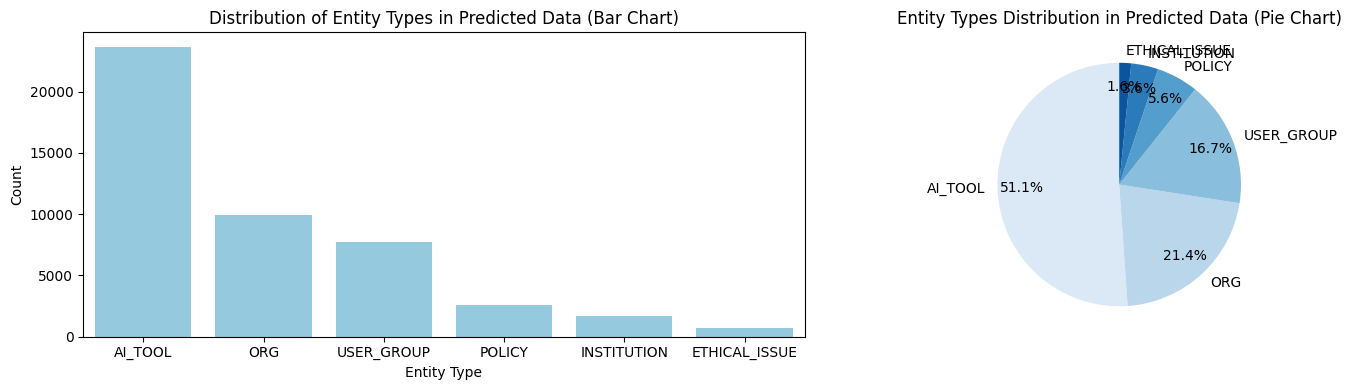

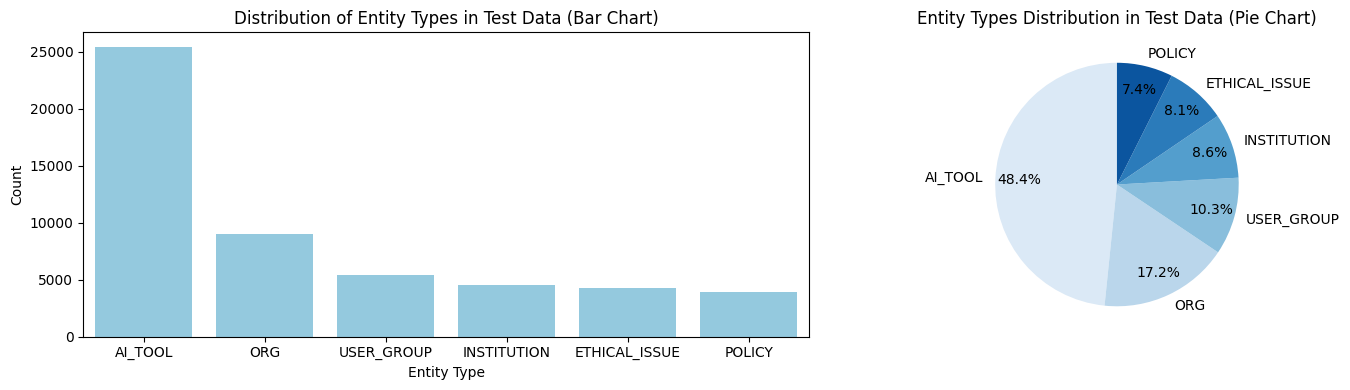

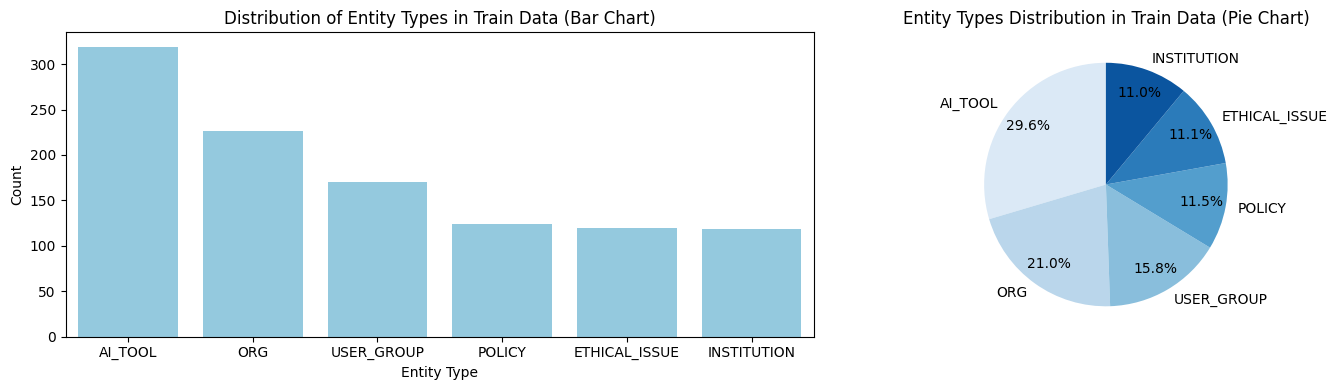

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def plot_entity_distribution(df, label_column, title_name):
    """
    Function to plot the distribution of entity labels in the provided dataframe.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column that contains the entity labels.

    Returns:
    None: Displays a bar and pie chart for entity distribution.
    """

    # Count the occurrences of each entity label in the specified column
    entity_counts = Counter(df[label_column])

    # Sort the entity counts by value in descending order
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels, sorted_values = zip(*sorted_entities)

    # Create a figure with a specific size
    plt.figure(figsize=(15, 4))

    # Plot the bar chart (1st subplot)
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(sorted_labels), y=list(sorted_values), color='skyblue')
    plt.title(f"Distribution of Entity Types in {title_name} Data (Bar Chart)")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")

    # Plot the pie chart (2nd subplot)
    plt.subplot(1, 2, 2)
    plt.pie(list(sorted_values), labels=list(sorted_labels), autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette("Blues", len(entity_counts)), labeldistance=1.1, pctdistance=0.8)
    plt.title(f"Entity Types Distribution in {title_name} Data (Pie Chart)")

    # Adjust layout and display the overall title
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_entity_distribution(entity_freq_pred, 'entity', "Predicted")

plot_entity_distribution(entity_freq_test, 'entity', "Test")

plot_entity_distribution(entity_freq_train, 'entity', "Train")

### Top 20% frequency of words in each entity

- Only ORG and AI_TOOL have valid words found

In [ ]:
# Group by entity and comment to count occurrences
comment_freq = model_output_without_OTHER.groupby(['entity', 'comment']).size().reset_index(name='count')

# For each entity, get the top 5% most frequent comments
top_comments = comment_freq.groupby('entity').apply(
    lambda group: group.nlargest(max(1, int(len(group) * 0.20)), 'count')
).reset_index(drop=True)

print(top_comments)

         entity  comment  count
0       AI_TOOL  ChatGPT   6897
1       AI_TOOL      GPT   5194
2       AI_TOOL      gpt   1715
3       AI_TOOL      app    872
4       AI_TOOL       OP    864
..          ...      ...    ...
389  USER_GROUP     rust     12
390  USER_GROUP   trusts     12
391  USER_GROUP      err     11
392  USER_GROUP    rests     11
393  USER_GROUP      dns     10

[394 rows x 3 columns]


<ipython-input-104-f3234e42dfde>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_comments = comment_freq.groupby('entity').apply(


#### Valid ORG words
- Google
- AMD
- TSMC
- CNN
- FSD
- TED
- FDA
- AMC
- CDC

Limitations:

- Some organisations may have been wrongly labeled as OTHER instead of ORG.
E.g. "Tesla" was labeled under OTHER. This is due to the training dataset not having the word "Tesla" at all.
- "Gov" is labeled as ORG instead of INSTITUTION
- "DSM" (Diagnostic and Statistical Manual of Mental Disorders) is wrongly
 labeled as ORG when it is a handbook and not an organisation


In [ ]:
pd.set_option('display.max_rows', None)
top_comments[top_comments['entity'] == 'ORG']

,entity,comment,count
198,ORG,go,3357
199,ORG,Google,1885
200,ORG,D,473
201,ORG,g,411
202,ORG,egg,334
203,ORG,M,258
204,ORG,Go,218
205,ORG,bug,120
206,ORG,Q,92
207,ORG,cuz,79


In [ ]:
top_comments[top_comments['entity'] == 'ORG'].count()

,0
entity,104
comment,104
count,104


#### Valid AI_TOOL words
- Different variations of writing ChatGPT (e.g. GPT, chatGPT etc.)

In [ ]:
pd.set_option('display.max_rows', None)
display(top_comments[top_comments['entity'] == 'AI_TOOL'])

,entity,comment,count
0,AI_TOOL,ChatGPT,6897
1,AI_TOOL,GPT,5194
2,AI_TOOL,gpt,1715
3,AI_TOOL,app,872
4,AI_TOOL,OP,864
5,AI_TOOL,chatGPT,707
6,AI_TOOL,F,638
7,AI_TOOL,C,382
8,AI_TOOL,GPTs,251
9,AI_TOOL,ChatGPTs,198


In [ ]:
top_comments[top_comments['entity'] == 'AI_TOOL'].count()

,0
entity,154
comment,154
count,154


#### Valid ETHICAL_ISSUE words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'ETHICAL_ISSUE']

,entity,comment,count
154,ETHICAL_ISSUE,m,170
155,ETHICAL_ISSUE,pizza,68
156,ETHICAL_ISSUE,gb,58
157,ETHICAL_ISSUE,z,44
158,ETHICAL_ISSUE,mm,35
159,ETHICAL_ISSUE,gf,21
160,ETHICAL_ISSUE,Prize,17
161,ETHICAL_ISSUE,bbc,16
162,ETHICAL_ISSUE,Pfizer,13
163,ETHICAL_ISSUE,zip,13


In [ ]:
top_comments[top_comments['entity'] == 'ETHICAL_ISSUE'].count()

,0
entity,23
comment,23
count,23


#### Valid INSTITUTION words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'INSTITUTION']

,entity,comment,count
177,INSTITUTION,vs,472
178,INSTITUTION,cell,147
179,INSTITUTION,llm,147
180,INSTITUTION,K,145
181,INSTITUTION,v,123
182,INSTITUTION,eggs,110
183,INSTITUTION,llms,95
184,INSTITUTION,cells,84
185,INSTITUTION,l,27
186,INSTITUTION,ngl,24


In [ ]:
top_comments[top_comments['entity'] == 'INSTITUTION'].count()

,0
entity,21
comment,21
count,21


#### Valid POLICY words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'POLICY']

,entity,comment,count
302,POLICY,Plus,275
303,POLICY,R,235
304,POLICY,girl,185
305,POLICY,P,161
306,POLICY,gun,103
307,POLICY,drug,88
308,POLICY,PR,83
309,POLICY,leg,75
310,POLICY,Put,61
311,POLICY,Run,61


In [ ]:
top_comments[top_comments['entity'] == 'POLICY'].count()

,0
entity,52
comment,52
count,52


#### Valid USER_GROUP words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'USER_GROUP']

,entity,comment,count
354,USER_GROUP,redd,1205
355,USER_GROUP,s,1121
356,USER_GROUP,d,682
357,USER_GROUP,rest,646
358,USER_GROUP,trust,643
359,USER_GROUP,tests,427
360,USER_GROUP,cut,356
361,USER_GROUP,S,262
362,USER_GROUP,turns,249
363,USER_GROUP,nd,152


In [ ]:
top_comments[top_comments['entity'] == 'USER_GROUP'].count()

,0
entity,40
comment,40
count,40


## Spacy's Dispacy Library Entity Visualizer

### Good example
i would disagree with this although i am talking from a university level graded exams are just rote learning things as fast as you can which you forget as soon as the exam is over however essays etc are a great way to assess true understanding of a subject there is a simple solution to this just have essays get rid of exams and make students defend their essays basically they have to talk about their essay infront of you answer questions etc this way if they do not truly understand it it is clear they cheated it is quite easy to see if someone truly understands a subject by just asking them about what they wrote  if they spent a week writing it they will damn sure know it even if they did learn all of their info from gpt well they learned it

In [ ]:
pd.set_option('display.max_rows', None)
train_df_reordered[12352:12497]

,comment,pos_tag,entity
12352,I,PRP,OTHER
12353,would,MD,OTHER
12354,disagree,NN,OTHER
12355,with,IN,OTHER
12356,this,DT,OTHER
12357,although,IN,OTHER
12358,I,PRP,OTHER
12359,am,VBP,OTHER
12360,talking,VBG,OTHER
12361,from,IN,OTHER


In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
colors = {"ORG":"orange", "AI_TOOL":"yellow", "INSTITUTION":"green", "USER_GROUP":"pink", "POLICY":"purple", "ETHICAL_ISSUE":"red"}
ex = [{"text": "I would disagree with this although I am talking from a University level Graded exams are just rote learning things as fast as you can which you forget as soon as the exam is over However essays etc are a great way to assess TRUE understanding of a subject There is a simple solution to this Just have essays get rid of exams and make students defend their essays Basically they have to talk about their essay infront of you answer questions etc this way if they do not truly understand it it is clear they cheated it is quite easy to see if someone truly understands a subject by just asking them about what they wrote if they spent a week writing it they will damn sure know it Even if they did learn all of their info from GPT well they learned it",
       "ents": [{"start": 56, "end": 66, "label": "INSTITUTION"}, {"start": 335, "end": 343, "label": "USER_GROUP"}, {"start": 507, "end": 514, "label": "ETHICAL_ISSUE"}, {"start":726, "end": 729, "label": "AI_TOOL"}],
       "title": "Good Example"}]
displacy.render(ex, style="ent", options={"colors":colors}, manual=True)

**Explanation:**

The CRF model correctly identified 4 words in the comment as valid entities. This comment shows the public's views on using AI in education and the ethicality of it in terms of the behaviour of students cheating


*   "University" ---> INSTITUTION
*   "student" ---> USER_GROUP
*   "cheated" ---> ETHICAL_ISSUE
*   "GPT" ---> AI_TOOL



### Bad Example
everyone dunking on tesla but not realizing openai is partially an elon musk company and teslas head of ai now works on openai  the irony is too funny guess im on reddit after all

In [ ]:
test_df2[187943:187977]

,comment,entity,pos_tag
187943,Everyone,OTHER,NN
187944,dunking,OTHER,VBG
187945,on,OTHER,IN
187946,Tesla,OTHER,NN
187947,but,OTHER,CC
187948,not,OTHER,RB
187949,realizing,OTHER,VBG
187950,OpenAI,AI_TOOL,NN
187951,is,OTHER,VBZ
187952,partially,OTHER,RB


In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
colors = {"ORG":"orange", "AI_TOOL":"yellow", "INSTITUTION":"green", "USER_GROUP":"pink", "POLICY":"purple", "ETHICAL_ISSUE":"red"}
ex = [{"text": "Everyone dunking on Tesla but not realizing OpenAI is partially an Elon Musk company and Teslas head of AI now works on OpenAI the irony is too funny Guess Im on reddit after all",
       "ents": [{"start": 44, "end": 50, "label": "AI_TOOL"}, {"start": 120, "end": 126, "label": "AI_TOOL"}],
       "title": "Bad Example"}]
displacy.render(ex, style="ent", options={"colors":colors}, manual=True)

**Explanation:**

The CRF model only identified "OpenAI" in the comment as a valid entity and labeled it as under AI_TOOL category. "Tesla" and "Reddit" was identified as OTHER instead of ORG. Words identified as OTHER category are not highlighted specifically since it makes up majority of the sentence.


*   "OpenAI" ---> INSTITUTION
*   "Tesla" ---> ORG (not labeled by model)
*   "reddit" ---> ORG (not labeled by model)

# Attempt with Additional Preprocessing - Lowercasing, Removing Stopwords and Keeping only words with at least 2 characters

Additional preprocessing in comment column for train and test dataset
- Convert all words to lowercase
- Remove stop words
- Ensure at least 2 characters are in each word

In [ ]:
# Updated Entity Categories (training dataset)
# OTHER ---- words not belonging to the other entities
# ORG: "Apple", "APPLE", "Google", "google", "Microsoft", "microsoft", "Bing", "YouTube", "youtube", "TED", "Quora", "stackoverflow", "stack overflow", "quizlet", "Siri", "Alexa", "Course Hero", "Nvidia", "nvidia", "NVIDIA", "CPG", "Eleven Labs", "patreon", "Twitter", "X", "duolingo", "DuoLingo", "Duolingo", "Blackberry", "Facebook", "FaceBook", "Grammarly", "Starlink", "TMobile", "Symbolab", "Buzzfeed", "buzzfeed"
# AI_TOOL: "ChatGPT", "GPT", "GPTs", "gpt", "CGPT", "Chat GPT", "chat gpt", "chat GPT", "ChatGPTs", "chatgpt", "chatGPT", "OpenAI", "OpenAIs", "Open AIs", "openais", "open AI", "Open AI", "Open ai", "Anthropic", "Claude", "DeepSeek", "Gemini", "Perplexity", "Copilot", "MSCopilot", "DALLE", "StableDiffusion", "Stability AI", "LLAMA", "LLaMa", "copilot", "Bard", "Deepmind", "huggingface", "Hugging Face", "Gemini", "Claude", "anthropic", "Opus", "HeyPi"
# ETHICAL_ISSUE: "ethics", "ethical", "shady", "illegal", "criminals", "Banning", "banning", "banned", "ban", "bans", "crime", "crimes", "criminalization", "illegalize", "bias", "biased", "biases", "forbidden", "forbid", "criminalize", "restraint", "nefariously", "disinformation", "misinformation", "Misrepresentation", "misrepresent", "exploit", "exploits", "exploited", "exploiting", "cheating", "cheat", "cheated", "academic misconduct", "Plagiarism", "plagiarism", "plagarizes"
# INSTITUTION: "university", "University", "universities", "institution", "institutions", "academy", "college", "colleges", "school", "schools", "institute", "faculty", "department", "campus", "lecture hall", "alma mater", "Ivy League", "community college", "research institute", "think tank", "academic conference", "Bearsden Academy", "Khan Academy", "Ministry", "agency", "MIT", "elementary school", "primary school", "middle school", "highschool", "high school", "grad school", "grade school", "governments", "government", "Government", "gov", "Federal government", "federal government", "federal agencies", "state government", "conference"
# POLICY: "AI policy", "education guideline", "plagiarism policy", "intellectual property", "honor system", "honor code", "governmental regulation", "regulation", "regulations", "regulate", "regulated", "regulating", "regulatory", "unregulated", "federal laws", "law", "laws", "Laws", "Law", "govern", "governed", "punishments", "legislation", "fieldlaw", "legal", "lawrule", "federal", "enforcement", "policies", "honours", "guidelines", "POSIX", "HIPAA", "Bill of Rights", "UBI"
# USER_GROUP: "student", "students", "student TA", "ProfTA", "professor", "professors", "assistant professor", "associate professor", "adjunct professor", "lecturer", "lecturers", "instructor", "instructors", "educator", "educators", "teacher", "teachers", "Teachers", "tutor", "tutors", "mentor", "mentors", "scholar", "academician", "dean", "chancellor", "researcher", "researchers", "Researchers", "PhD", "postdoc", "fellow", "visiting scholar", "teaching assistant", "research assistant", "high school students", "theoretician", "philosophers", "ethicists", "undergrad", "freshman", "Scholar", "scholar", "scholars"

## Manually labeled training data using Excel on top of what was done by ChatGPT


*   Added in ORG (ORGANISATION) entity
*   Added more keywords for other existing entities



In [ ]:
# Around 50k rows as training data
train_df = pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_train_with_org.csv")
train_df.head(20)

,comment,pos_tag,entity
0,Try,VB,OTHER
1,a,DT,OTHER
2,google,NN,ORG
3,search,NN,OTHER
4,and,CC,OTHER
5,limit,NN,OTHER
6,it,PRP,OTHER
7,to,TO,OTHER
8,before,IN,OTHER
9,ChatGPT,NN,AI_TOOL


In [ ]:
train_df.shape

(50884, 3)

## Redo pos_tag column

In [ ]:
# Removed 'gt' value from words using Excel
# Words might have been wrongly tagged due to 'gt' value
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
# Check Nan values
print(train_df.isna().sum())

comment    0
pos_tag    0
entity     0
dtype: int64


In [ ]:
# Remove existing pos_tag column
train_df = train_df.astype(str)
train_df = train_df.drop('pos_tag', axis=1)

# Add POS tags
train_df['pos_tag'] = train_df['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])

# Reorder columns
train_df_reordered = train_df[['comment', 'pos_tag', 'entity']]
train_df_reordered.head()

,comment,pos_tag,entity
0,Try,VB,OTHER
1,a,DT,OTHER
2,google,NN,ORG
3,search,NN,OTHER
4,and,CC,OTHER


In [ ]:
# No change in rows and columns since there are no Nan values
train_df_reordered.shape

(50884, 3)

In [ ]:
# Convert to lowercase
train_df_reordered['comment'] = train_df_reordered['comment'].str.lower()

In [ ]:
# Remove stop words
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download stopwords (only once)
nltk.download('stopwords')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Filter out rows where the 'comment' is a stopword
train_df_no_stopwords = train_df_reordered[~train_df_reordered['comment'].str.lower().isin(stop_words)]

# Print number of removed rows
print(f"Removed {len(train_df_reordered) - len(train_df_no_stopwords)} stopword rows.")


Removed 25246 stopword rows.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df_no_stopwords.head(20)

,comment,pos_tag,entity
0,try,VB,OTHER
2,google,NN,ORG
3,search,NN,OTHER
5,limit,NN,OTHER
9,chatgpt,NN,AI_TOOL
13,anything,NN,OTHER
19,find,VB,OTHER
21,many,JJ,OTHER
22,references,NNS,OTHER
24,brandon,NN,OTHER


In [ ]:
train_df_no_stopwords.shape

(25638, 3)

In [ ]:
# Ensure at least 2 characters are in each word
train_df_filtered = train_df_no_stopwords[train_df_no_stopwords['comment'].str.len() >= 2]

# Show how many rows were removed
print(f"Removed {len(train_df_no_stopwords) - len(train_df_filtered)} rows with comments shorter than 2 characters.")

Removed 48 rows with comments shorter than 2 characters.


In [ ]:
train_df_filtered.shape

(25590, 3)

## Add in POS tag for Test Dataset 1 and 2


ChatGPT removed pos_tag column when labeling Test Dataset 1 and renamed comment column to word column
<br></br>
To ensure consistency:

* Change Test Dataset 1 word column to comment column
* Remove the existing pos_tag column in Test Dataset 2 and add in new pos_tag column in both Test Dataset 1 and 2





In [ ]:
# Entities labeled by ChatGPT
# https://chatgpt.com/share/67daeb35-d788-8008-991c-26b3e347dc41
test_df = pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_test1_labeled_with_org.csv")
test_df.head(20)

,word,entity
0,Kids,OTHER
1,do,OTHER
2,not,OTHER
3,show,OTHER
4,disinterest,OTHER
5,in,OTHER
6,school,INSTITUTION
7,because,OTHER
8,they,OTHER
9,are,OTHER


In [ ]:
# Rename word column to comment column
test_df.rename(columns={'word':'comment'}, inplace=True)

# Add POS tags
test_df['pos_tag'] = test_df['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])

# Reorder columns
test_df_reordered = test_df[['comment', 'pos_tag', 'entity']]
test_df_reordered.head()

,comment,pos_tag,entity
0,Kids,NNS,OTHER
1,do,VB,OTHER
2,not,RB,OTHER
3,show,NN,OTHER
4,disinterest,NN,OTHER


In [ ]:
# Convert to lowercase
test_df_reordered['comment'] = test_df_reordered['comment'].str.lower()

In [ ]:
# Filter out rows where the 'comment' is a stopword
test_df_no_stopwords = test_df_reordered[~test_df_reordered['comment'].str.lower().isin(stop_words)]

# Print number of removed rows
print(f"Removed {len(test_df_reordered) - len(test_df_no_stopwords)} stopword rows.")

Removed 24628 stopword rows.


In [ ]:
test_df_no_stopwords.head(20)

,comment,pos_tag,entity
0,kids,NNS,OTHER
3,show,NN,OTHER
4,disinterest,NN,OTHER
6,school,NN,INSTITUTION
11,interested,JJ,OTHER
13,learning,VBG,OTHER
14,anything,NN,OTHER
18,show,NN,OTHER
19,disinterest,NN,OTHER
24,practical,JJ,OTHER


In [ ]:
test_df_no_stopwords.shape

(25395, 3)

In [ ]:
# Ensure at least 2 characters are in each word
test_df_filtered = test_df_no_stopwords[test_df_no_stopwords['comment'].str.len() >= 2]

# Show how many rows were removed
print(f"Removed {len(test_df_no_stopwords) - len(test_df_filtered)} rows with comments shorter than 2 characters.")

Removed 84 rows with comments shorter than 2 characters.


In [ ]:
test_df_filtered.shape

(25311, 3)

In [ ]:
# Entities labeled by ChatGPT
# https://chatgpt.com/share/67f0e295-5268-8008-ac33-6aa0aea27067
test_df2= pd.read_csv("/content/drive/MyDrive/IS450 Text Mining/NER_test2_labeled_with_org.csv")
test_df2.head(20)

,comment,pos_tag,entity
0,If,IN,OTHER
1,you,PRP,OTHER
2,do,VB,OTHER
3,not,RB,OTHER
4,mind,NN,OTHER
5,I,PRP,OTHER
6,can,MD,OTHER
7,write,NN,OTHER
8,you,PRP,OTHER
9,a,DT,OTHER


In [ ]:
# Remove existing pos_tag column in Test Dataset 2
test_df2 = test_df2.drop('pos_tag', axis=1)

# Add POS tags
test_df2['pos_tag'] = test_df2['comment'].apply(lambda x: nltk.pos_tag([x])[0][1])

# Reorder columns
test_df2_reordered = test_df2[['comment', 'pos_tag', 'entity']]
test_df2_reordered.head()

,comment,pos_tag,entity
0,If,IN,OTHER
1,you,PRP,OTHER
2,do,VB,OTHER
3,not,RB,OTHER
4,mind,NN,OTHER


In [ ]:
test_df2_reordered.shape

(4301035, 3)

In [ ]:
# Convert to lowercase
test_df2_reordered['comment'] = test_df2_reordered['comment'].str.lower()

In [ ]:
# Filter out rows where the 'comment' is a stopword
test_df2_no_stopwords = test_df2_reordered[~test_df2_reordered['comment'].str.lower().isin(stop_words)]

# Print number of removed rows
print(f"Removed {len(test_df2_reordered) - len(test_df2_no_stopwords)} stopword rows.")

Removed 2136631 stopword rows.


In [ ]:
test_df2_no_stopwords.head(20)

,comment,pos_tag,entity
4,mind,NN,OTHER
7,write,NN,OTHER
10,private,JJ,OTHER
11,message,NN,OTHER
12,httpspreview,NN,OTHER
13,redd,NN,OTHER
14,itxjozlrfe,NN,OTHER
15,jpegwidthampformatpjpgampautowebpampsefddaceca...,NN,OTHER
16,works,NNS,OTHER
17,fine,NN,OTHER


In [ ]:
test_df2_no_stopwords.shape

(2164404, 3)

In [ ]:
# Ensure at least 2 characters are in each word
test_df2_filtered = test_df2_no_stopwords[test_df2_no_stopwords['comment'].str.len() >= 2]

# Show how many rows were removed
print(f"Removed {len(test_df2_no_stopwords) - len(test_df2_filtered)} rows with comments shorter than 2 characters.")

Removed 7753 rows with comments shorter than 2 characters.


In [ ]:
test_df_filtered.shape

(25311, 3)

In [ ]:
test_df2_filtered.shape

(2156651, 3)

## Run model with Test Dataset 1

---



In [ ]:
# Prepare train dataset - features and target
X_train = train_df_filtered.drop(['pos_tag','entity'], axis=1)
y_train = train_df_filtered['entity']

In [ ]:
X_train = X_train.to_numpy().tolist()
y_train = y_train.to_numpy().tolist()
y_train = [[item] for item in y_train]

In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_train for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 24515, 'AI_TOOL': 319, 'ORG': 225, 'USER_GROUP': 170, 'POLICY': 122, 'ETHICAL_ISSUE': 120, 'INSTITUTION': 119})


In [ ]:
print(type(X_train), type(y_train))
print(len(X_train), len(y_train))

<class 'list'> <class 'list'>
25590 25590


In [ ]:
# Prepare train dataset - features and target
X_test = test_df_filtered.drop(['pos_tag','entity'], axis=1)
y_test = test_df_filtered['entity']

In [ ]:
X_test = X_test.to_numpy().tolist()
X_test

[['kids'],
 ['show'],
 ['disinterest'],
 ['school'],
 ['interested'],
 ['learning'],
 ['anything'],
 ['show'],
 ['disinterest'],
 ['practical'],
 ['way'],
 ['cater'],
 ['education'],
 ['natural'],
 ['interests'],
 ['would'],
 ['happy'],
 ['wrong'],
 ['honestly'],
 ['seeing'],
 ['kids'],
 ['use'],
 ['ai'],
 ['purpose'],
 ['know'],
 ['children'],
 ['family'],
 ['talking'],
 ['primary'],
 ['school'],
 ['probably'],
 ['kids'],
 ['would'],
 ['need'],
 ['display'],
 ['initiative'],
 ['use'],
 ['chatgpt'],
 ['tutoring'],
 ['see'],
 ['happening'],
 ['cases'],
 ['tinkered'],
 ['chatgpt'],
 ['third'],
 ['grade'],
 ['students'],
 ['love'],
 ['apprciate'],
 ['kind'],
 ['mostly'],
 ['fair'],
 ['feedback'],
 ['laugh'],
 ['silly'],
 ['mistakes'],
 ['like'],
 ['enables'],
 ['everyone'],
 ['classroom'],
 ['learn'],
 ['used'],
 ['write'],
 ['podcast'],
 ['script'],
 ['ai'],
 ['gathered'],
 ['really'],
 ['insightful'],
 ['thoughts'],
 ['along'],
 ['way'],
 ['laziest'],
 ['readers'],
 ['enthralled'],
 ['c

In [ ]:
y_test = y_test.to_numpy().tolist()
y_test = [[item] for item in y_test]
y_test

[['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['INSTITUTION'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['INSTITUTION'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['AI_TOOL'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['AI_TOOL'],
 ['OTHER'],
 ['OTHER'],
 ['USER_GROUP'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHE

In [ ]:
print(type(X_test), type(y_test))
print(len(X_test), len(y_test))

<class 'list'> <class 'list'>
25311 25311


In [ ]:
# Build the CRF model with additional parameters for improved accuracy
crf = CRF(
    c1=0.1,                      # L1 regularization term (helps prevent overfitting)
    c2=0.1,                      # L2 regularization term (helps prevent overfitting)
    max_iterations=200,          # Maximum iterations for convergence (you can adjust based on your dataset)
    all_possible_transitions=True,  # Enable all possible transitions between labels
    verbose=False                  # Print progress during training
)

# Fit the model to the training data
crf.fit(X_train, y_train)

CRF(all_possible_transitions=True, c1=0.1, c2=0.1, max_iterations=200)

In [ ]:
y_pred = crf.predict(X_test)

In [ ]:
print(y_pred)

[['OTHER']
 ['OTHER']
 ['OTHER']
 ...
 ['OTHER']
 ['OTHER']
 ['OTHER']]


In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_pred for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 25016, 'AI_TOOL': 190, 'USER_GROUP': 48, 'ORG': 45, 'POLICY': 12})


In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_test for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 24728, 'AI_TOOL': 196, 'POLICY': 135, 'INSTITUTION': 80, 'USER_GROUP': 67, 'ETHICAL_ISSUE': 63, 'ORG': 42})


In [ ]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,0)))

Predicted F1-Score : 97.0 % 


In [ ]:
# Flatten the sequences (multi-label data)
y_test_flat = [label for sublist in y_test for label in sublist]
y_pred_flat = [label for sublist in y_pred for label in sublist]

# Classification report
print(classification_report(y_test_flat, y_pred_flat))

               precision    recall  f1-score   support

      AI_TOOL       0.86      0.83      0.84       196
ETHICAL_ISSUE       0.00      0.00      0.00        63
  INSTITUTION       0.00      0.00      0.00        80
          ORG       0.00      0.00      0.00        42
        OTHER       0.98      0.99      0.99     24728
       POLICY       0.00      0.00      0.00       135
   USER_GROUP       0.00      0.00      0.00        67

     accuracy                           0.98     25311
    macro avg       0.26      0.26      0.26     25311
 weighted avg       0.97      0.98      0.97     25311



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision and recall and f1 score increased with the additional preprocessing steps for AI_TOOL entity type. However, there is no visible metrics score for ORG entity type which means that prediction for ORG is worse than without additional preprocessing. OTHER entity type's precision has a slight decrease from 0.99 to 0.98 compared to without additional preprocessing.
<br></br>
Based on AI_TOOL entity type:

**No Additional Preprocessing (Test Dataset 1 - 50k+ data)**

Precision: 0.60, Recall: 0.78, F1-score: 0.68

**No Additional Preprocessing (Test Dataset 2 - 4 million+ data)**

Precision: 0.65, Recall: 0.60, F1-score: 0.62


## Run model with Test Dataset 2

In [ ]:
# Prepare train dataset - features and target
X_test2 = test_df2_filtered.drop(['pos_tag','entity'], axis=1)
y_test2 = test_df2_filtered['entity']

In [ ]:
X_test2 = X_test2.to_numpy().tolist()
X_test2

[['mind'],
 ['write'],
 ['private'],
 ['message'],
 ['httpspreview'],
 ['redd'],
 ['itxjozlrfe'],
 ['jpegwidthampformatpjpgampautowebpampsefddacecafabbfe'],
 ['works'],
 ['fine'],
 ['issue'],
 ['presents'],
 ['choices'],
 ['choose'],
 ['happen'],
 ['using'],
 ['prompt'],
 ['models'],
 ['likely'],
 ['prompted'],
 ['regexed'],
 ['place'],
 ['specific'],
 ['tags'],
 ['like'],
 ['ltchoicesgtltchoicesgt'],
 ['app'],
 ['prealpha'],
 ['httpsstreamable'],
 ['comvinbhttpsstreamable'],
 ['comvinb'],
 ['features'],
 ['fully'],
 ['featured'],
 ['fate'],
 ['accelerated'],
 ['gameplay'],
 ['structured'],
 ['encounters'],
 ['conflicts'],
 ['challenges'],
 ['contests'],
 ['well'],
 ['free'],
 ['form'],
 ['dice'],
 ['rolls'],
 ['iteminventory'],
 ['system'],
 ['characters'],
 ['locations'],
 ['items'],
 ['mooks'],
 ['generated'],
 ['onthefly'],
 ['needed'],
 ['character'],
 ['avatars'],
 ['location'],
 ['backgrounds'],
 ['comprehensive'],
 ['world'],
 ['buildermap'],
 ['editor'],
 ['ai'],
 ['assistant'

In [ ]:
y_test2 = y_test2.to_numpy().tolist()
y_test2 = [[item] for item in y_test2]
y_test2

[['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['OTHER'],
 ['O

In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_test2 for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 2105078, 'AI_TOOL': 25446, 'ORG': 8032, 'USER_GROUP': 5417, 'INSTITUTION': 4533, 'ETHICAL_ISSUE': 4241, 'POLICY': 3904})


In [ ]:
print(type(X_test2), type(y_test2))
print(len(X_test2), len(y_test2))

<class 'list'> <class 'list'>
2156651 2156651


In [ ]:
y_pred2 = crf.predict(X_test2)

In [ ]:
print(y_pred2)

[['OTHER']
 ['OTHER']
 ['OTHER']
 ...
 ['OTHER']
 ['OTHER']
 ['OTHER']]


In [ ]:
y_pred2_df = pd.DataFrame(y_pred2)
y_pred2_df.columns = ['entity']
X_test2_comment_df = test_df2_filtered.drop(['pos_tag','entity'], axis=1)

In [ ]:
# Make a new dataframe with data from X_test2 and y_pred
X_test2_comment_df.reset_index(drop=True, inplace=True)
y_pred2_df.reset_index(drop=True, inplace=True)
model_output = pd.concat([X_test2_comment_df, y_pred2_df], axis="columns")
model_output.head()

,comment,entity
0,mind,OTHER
1,write,OTHER
2,private,OTHER
3,message,OTHER
4,httpspreview,OTHER


In [ ]:
model_output.isna().sum()

,0
comment,0
entity,0


In [ ]:
X_test2_comment_df.isna().sum()

,0
comment,0


In [ ]:
y_pred2_df.isna().sum()

,0
entity,0


In [ ]:
model_output['entity'].value_counts()

,count
entity,
OTHER,2129119
AI_TOOL,19331
ORG,4911
USER_GROUP,2730
ETHICAL_ISSUE,270
POLICY,204
INSTITUTION,86


In [ ]:
# Remove OTHER entity from model output
model_output_without_OTHER = model_output[model_output['entity'] != 'OTHER']
model_output_without_OTHER['entity'].value_counts()

,count
entity,
AI_TOOL,19331
ORG,4911
USER_GROUP,2730
ETHICAL_ISSUE,270
POLICY,204
INSTITUTION,86


In [ ]:
model_output.shape

(2156651, 2)

In [ ]:
model_output_without_OTHER.shape

(27532, 2)

## Evaluation of Test Dataset 2

### Confusion Matrix

In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_pred2 for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 2129119, 'AI_TOOL': 19331, 'ORG': 4911, 'USER_GROUP': 2730, 'ETHICAL_ISSUE': 270, 'POLICY': 204, 'INSTITUTION': 86})


In [ ]:
from collections import Counter
flattened_list = [item for sublist in y_test2 for item in sublist]
value_counts = Counter(flattened_list)
print(value_counts)

Counter({'OTHER': 2105078, 'AI_TOOL': 25446, 'ORG': 8032, 'USER_GROUP': 5417, 'INSTITUTION': 4533, 'ETHICAL_ISSUE': 4241, 'POLICY': 3904})


In [ ]:
f1_score = metrics.flat_f1_score(y_test2, y_pred2, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,0)))

Predicted F1-Score : 97.0 % 


In [ ]:
# Flatten the sequences (multi-label data)
y_test_flat2 = [label for sublist in y_test2 for label in sublist]
y_pred_flat2 = [label for sublist in y_pred2 for label in sublist]

# Classification report
print(classification_report(y_test_flat2, y_pred_flat2))

               precision    recall  f1-score   support

      AI_TOOL       0.86      0.65      0.74     25446
ETHICAL_ISSUE       0.00      0.00      0.00      4241
  INSTITUTION       0.00      0.00      0.00      4533
          ORG       0.00      0.00      0.00      8032
        OTHER       0.98      0.99      0.99   2105078
       POLICY       0.00      0.00      0.00      3904
   USER_GROUP       0.00      0.00      0.00      5417

     accuracy                           0.98   2156651
    macro avg       0.26      0.24      0.25   2156651
 weighted avg       0.97      0.98      0.97   2156651



When comparing to without additional preprocessing, precision, recall and F1-score has increased significantly.

Compared to Test Dataset 1, precision remained unchanged while recall and F1-score decreased. Accuracy has remained at 98%.
<br/><br/>
Based on AI_TOOL entity:

**No Additional Preprocessing (Test Dataset 1 - 50k+ data)**

Precision: 0.60, Recall: 0.78, F1-score: 0.68

**No Additional Preprocessing (Test Dataset 2 - 4 million+ data)**

Precision: 0.65, Recall: 0.60, F1-score: 0.62

**With Additional Preprocessing (Test Dataset 1 - 50k+ data)**

Precision: 0.86, Recall: 0.83, F1-score: 0.84


### Entity Frequency (Bar and Pie Chart)

In [ ]:
# Model Predictions without OTHER entity type
entity_freq_pred =  model_output_without_OTHER[['entity']]
entity_freq_pred['entity'].unique()

array(['AI_TOOL', 'ORG', 'ETHICAL_ISSUE', 'USER_GROUP', 'POLICY',
       'INSTITUTION'], dtype=object)

In [ ]:
print(entity_freq_pred.shape)
entity_freq_pred = entity_freq_pred.dropna()
print(entity_freq_pred.shape)

(27532, 1)
(27532, 1)


In [ ]:
# Exclude OTHER entity type from test dataset
entity_freq_test = pd.DataFrame(y_test2)
entity_freq_test.columns = ['entity']

entity_freq_test_cleaned =  entity_freq_test[entity_freq_test['entity'] != 'OTHER']
entity_freq_test_cleaned['entity'].unique()

array(['AI_TOOL', 'ORG', 'USER_GROUP', 'POLICY', 'ETHICAL_ISSUE',
       'INSTITUTION'], dtype=object)

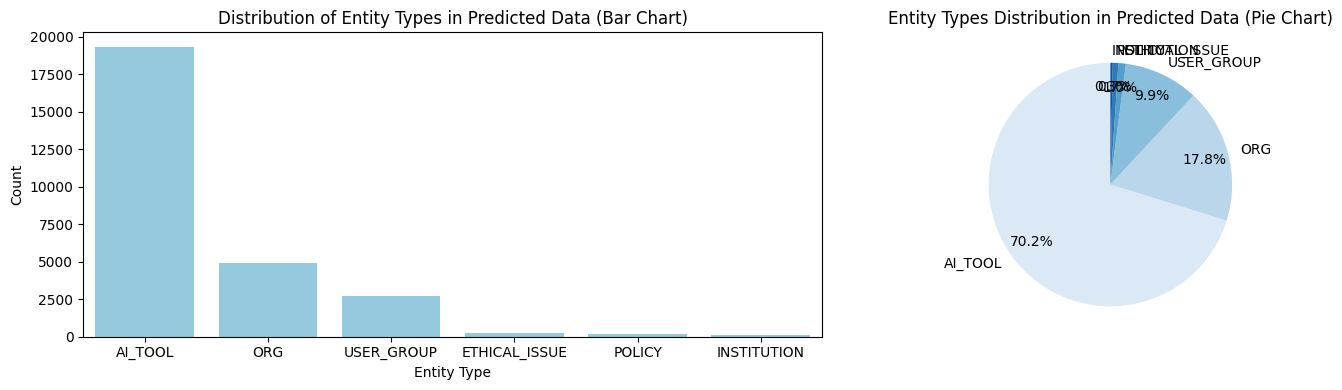

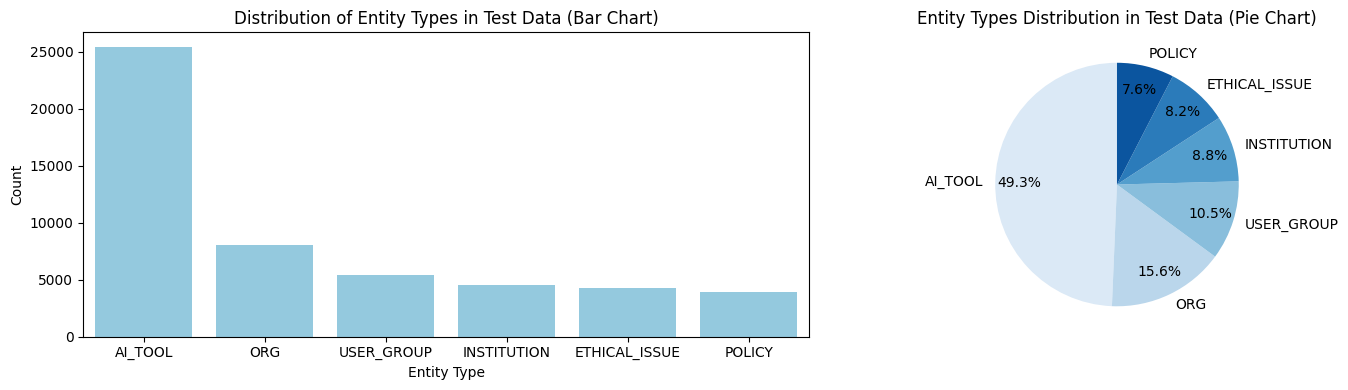

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def plot_entity_distribution(df, label_column, title_name):
    """
    Function to plot the distribution of entity labels in the provided dataframe.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column that contains the entity labels.

    Returns:
    None: Displays a bar and pie chart for entity distribution.
    """

    # Count the occurrences of each entity label in the specified column
    entity_counts = Counter(df[label_column])

    # Sort the entity counts by value in descending order
    sorted_entities = sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels, sorted_values = zip(*sorted_entities)

    # Create a figure with a specific size
    plt.figure(figsize=(15, 4))

    # Plot the bar chart (1st subplot)
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(sorted_labels), y=list(sorted_values), color='skyblue')
    plt.title(f"Distribution of Entity Types in {title_name} Data (Bar Chart)")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")

    # Plot the pie chart (2nd subplot)
    plt.subplot(1, 2, 2)
    plt.pie(list(sorted_values), labels=list(sorted_labels), autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette("Blues", len(entity_counts)), labeldistance=1.1, pctdistance=0.8)
    plt.title(f"Entity Types Distribution in {title_name} Data (Pie Chart)")

    # Adjust layout and display the overall title
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_entity_distribution(entity_freq_pred, 'entity', "Predicted")

plot_entity_distribution(entity_freq_test_cleaned, 'entity', "Test")

### Top 50% frequency of words in each entity

- Only ORG and AI_TOOL have valid words found
- Compared to Third Attempt, increased threshold from top 20% to top 50% since there are fewer words in current attempt

In [ ]:
# Group by entity and comment to count occurrences
comment_freq = model_output_without_OTHER.groupby(['entity', 'comment']).size().reset_index(name='count')

# For each entity, get the top 5% most frequent comments
top_comments = comment_freq.groupby('entity').apply(
    lambda group: group.nlargest(max(1, int(len(group) * 0.50)), 'count')
).reset_index(drop=True)

print(top_comments)

            entity         comment  count
0          AI_TOOL         chatgpt   9518
1          AI_TOOL             gpt   7009
2          AI_TOOL             app    921
3          AI_TOOL             ccp    176
4          AI_TOOL              pc    158
5          AI_TOOL             gap    125
6          AI_TOOL             png    123
7          AI_TOOL             cap    121
8          AI_TOOL             pop    119
9          AI_TOOL            gtgt     98
10         AI_TOOL         chatgtp     52
11         AI_TOOL             gtp     49
12         AI_TOOL            cgpt     48
13         AI_TOOL           patch     44
14         AI_TOOL             tap     44
15         AI_TOOL             npc     37
16         AI_TOOL             php     35
17         AI_TOOL       gtchatgpt     28
18         AI_TOOL              cc     26
19         AI_TOOL              cp     25
20         AI_TOOL             apt     24
21         AI_TOOL              ap     23
22         AI_TOOL              ph

<ipython-input-191-68c324a8a895>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_comments = comment_freq.groupby('entity').apply(


#### Valid ORG words
- Chegg

Limitations:

- Compared to Third Attempt, only 1 word labeled as ORG is valid


In [ ]:
top_comments[top_comments['entity'] == 'ORG']

,entity,comment,count
110,ORG,go,3580
111,ORG,egg,350
112,ORG,gb,207
113,ORG,bug,127
114,ORG,cuz,94
115,ORG,eg,89
116,ORG,og,36
117,ORG,gf,31
118,ORG,gig,30
119,ORG,fuzzy,27


In [ ]:
top_comments[top_comments['entity'] == 'ORG'].count()

,0
entity,47
comment,47
count,47


#### Valid AI_TOOL words
- Different variations of writing ChatGPT (e.g. GPT, chatGPT etc.)

In [ ]:
pd.set_option('display.max_rows', None)
display(top_comments[top_comments['entity'] == 'AI_TOOL'])

,entity,comment,count
0,AI_TOOL,chatgpt,9518
1,AI_TOOL,gpt,7009
2,AI_TOOL,app,921
3,AI_TOOL,ccp,176
4,AI_TOOL,pc,158
5,AI_TOOL,gap,125
6,AI_TOOL,png,123
7,AI_TOOL,cap,121
8,AI_TOOL,pop,119
9,AI_TOOL,gtgt,98


In [ ]:
top_comments[top_comments['entity'] == 'AI_TOOL'].count()

,0
entity,81
comment,81
count,81


#### Valid ETHICAL_ISSUE words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'ETHICAL_ISSUE']

,entity,comment,count
81,ETHICAL_ISSUE,nn,40
82,ETHICAL_ISSUE,cnn,36
83,ETHICAL_ISSUE,bbc,35
84,ETHICAL_ISSUE,bn,22
85,ETHICAL_ISSUE,bb,20
86,ETHICAL_ISSUE,cnbc,15
87,ETHICAL_ISSUE,bc,13
88,ETHICAL_ISSUE,biz,10
89,ETHICAL_ISSUE,zen,7
90,ETHICAL_ISSUE,az,5


In [ ]:
top_comments[top_comments['entity'] == 'ETHICAL_ISSUE'].count()

,0
entity,22
comment,22
count,22


#### Valid INSTITUTION words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'INSTITUTION']

,entity,comment,count
103,INSTITUTION,cv,42
104,INSTITUTION,vc,25
105,INSTITUTION,cr,4
106,INSTITUTION,nvcc,3
107,INSTITUTION,rc,2
108,INSTITUTION,crv,1
109,INSTITUTION,cvc,1


In [ ]:
top_comments[top_comments['entity'] == 'INSTITUTION'].count()

,0
entity,7
comment,7
count,7


#### Valid POLICY words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'POLICY']

,entity,comment,count
157,POLICY,url,86
158,POLICY,rl,46
159,POLICY,rug,20
160,POLICY,guru,11
161,POLICY,gl,9
162,POLICY,gru,6
163,POLICY,lull,5
164,POLICY,gr,2
165,POLICY,grr,2
166,POLICY,gulag,2


In [ ]:
top_comments[top_comments['entity'] == 'POLICY'].count()

,0
entity,11
comment,11
count,11


#### Valid USER_GROUP words
- No valid words found

In [ ]:
top_comments[top_comments['entity'] == 'USER_GROUP']

,entity,comment,count
168,USER_GROUP,trust,707
169,USER_GROUP,truth,613
170,USER_GROUP,th,482
171,USER_GROUP,st,162
172,USER_GROUP,rd,144
173,USER_GROUP,rs,78
174,USER_GROUP,hr,64
175,USER_GROUP,dr,60
176,USER_GROUP,sd,52
177,USER_GROUP,ds,31


In [ ]:
top_comments[top_comments['entity'] == 'USER_GROUP'].count()

,0
entity,45
comment,45
count,45
